# SUBMISSION : Exam Project VII (Part 01)
            (Submission by SHUBHAM KUMAR - Mat.# 5547548)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spo
import plotly.graph_objects as go
from itertools import combinations
from scipy.signal import butter, filtfilt, decimate, welch

# Load data
dataset = spo.loadmat("Proj_7-1.mat")

# Extracting all velocity readings, corresponding to 4 sensors spatially separated by 5cm in transverse dxn
v1 = dataset["V1"].squeeze()
v2 = dataset["V2"].squeeze()
v3 = dataset["V3"].squeeze()
v4 = dataset["V4"].squeeze()

# Storing them in an array of size (20000000,4)--> such that columns represent each sensor
data = np.stack((v1, v2, v3, v4), axis=1)
print(f"'data' array contains {data.shape[0]} readings per sensor across {data.shape[1]} sensors,\n spatially seperated in transverse direction by 5cm ")


'data' array contains 20000000 readings per sensor across 4 sensors,
 spatially seperated in transverse direction by 5cm 


### Task 1.1

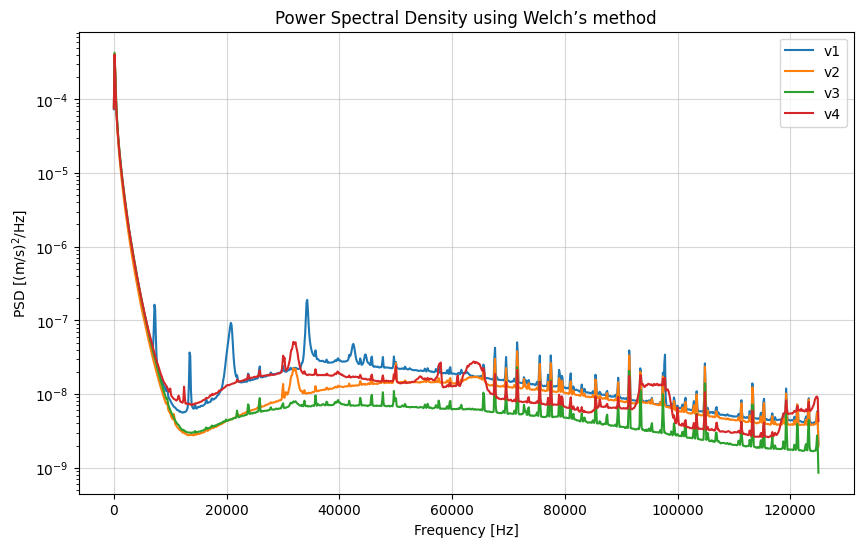

In [2]:
"""
------------------------ TASK 1.1 -----------------------------------------------
Analyze the frequency content of the velocity signals and identify the dominant frequency range. 
This helped determine whether the data is oversampled and guided the choice of an appropriate downsampling factor.
Computing the power spectral density (PSD) using Welch’s method for each channel.
Parameters:
    data (np.ndarray): 2D array of shape (20000000, 4)
    fs (float): Sampling frequency in Hz
    nperseg (int): Length of each segment for Welch method
"""

fs = 250000          # sampling frequency

# Computing PSD for all velocities
f_v1, Pxx_v1 = welch(data[:, 0], fs=fs, nperseg=2048)
f_v2, Pxx_v2 = welch(data[:, 1], fs=fs, nperseg=2048)
f_v3, Pxx_v3 = welch(data[:, 2], fs=fs, nperseg=2048)
f_v4, Pxx_v4 = welch(data[:, 3], fs=fs, nperseg=2048)

# Plot PSD
plt.figure(figsize=(10, 6))
plt.semilogy(f_v1, Pxx_v1, label='v1')
plt.semilogy(f_v2, Pxx_v2, label='v2')
plt.semilogy(f_v3, Pxx_v3, label='v3')
plt.semilogy(f_v4, Pxx_v4, label='v4')
plt.title('Power Spectral Density using Welch’s method')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [(m/s)$^2 $/Hz]')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


"""
Comments and Observations :
    - Yes, the data is significantly oversampled, relative to dominant frequency content.
    - As the strongest energies lie below 10kHz frequency. And everything above 50-60kHz is mainly noise.

Computing Downsampling Factor :
    - Taking maximum significant frequency as 10 kHz
    - Per Nyquist theorem ==> we get minimum sampling frequency = 2 * 10 kHz = 20 kHz
    - Downsampling factor ==>  250kHz / 20kHz = 12.5
    - The new rate is more efficient for computing, with no loss of relevant turbulence velocity data.
""";


### Task 1.2

In [3]:
"""
------------------------ TASK 1.2 -----------------------------------------------
Filtering the velocity data to remove the high frequencies before downsampling to avoid aliasing.
Later filtered velocity data is then downsampled to keep the relevant velocity turbulent data for later processing.

"""

def butter_lowpass_filter(data, cutoff, fs, order=4):     # Apply a low-pass Butterworth filter
    """
    Remove high frequencies before downsampling to avoid aliasing
    Parameters:
        - data: np.ndarray, the input velocity data (1D)
        - cutoff: float, cutoff frequency in Hz
        - fs: float, sampling frequency in Hz
        - order: int, order of the filter
    Returns:
        - Filtered velocity data
    """
    nyq = 0.5 * fs                             # Nyquist frequency of the original data
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, data)                # filtered output velocity data

def filter_and_downsample(data, cutoff, fs, downsample_factor, order=4):
    """
    Filter and downsample velocity data
    Parameters:
        - data: np.ndarray, the input velocity data (1D)
        - cutoff: float, cutoff frequency in Hz
        - fs: float, sampling frequency in Hz
        - order: int, order of the filter
        - downsample_factor: int, factor by which to downsample.
    Returns:
        - Downsampled filtered velocity data
    """
    filtered = butter_lowpass_filter(data, cutoff, fs, order=4)
    return decimate(filtered, downsample_factor)


cutoff = 10000                        # given 10 kHz cutoff frequency
downsample_factor = 20                # given downsample by a factor of 20
fs_down = fs // downsample_factor     # 250kHz / 20 = 12.5 kHz
downsampled_vel = []                  # empty list to store filterd + downsampled velocity signal for all 4 channels

for column in range(data.shape[1]):
    ds = filter_and_downsample(data[:,column], cutoff, fs, downsample_factor)
    downsampled_vel.append(ds)
filtered_downsampled_data = np.array(downsampled_vel)    # converting to array for easy data extraction

print(f"Filtered the velocity data to remove the high frequencies to avoid aliasing at {cutoff} Hz cutoff frequency.")
print(f"Downsampled the filtered velocity data to remove noise and retain relevant turbulent data with factor {downsample_factor}.")
print(f"Resulted in relevant and more manageable velocity signal data of size {filtered_downsampled_data.shape[1]}, for all {filtered_downsampled_data.shape[0]} velocities.")

# ---------------------------------------------------------
# Below is the same code as above, in a more raw form
# ---------------------------------------------------------
# # Apply to both velocity components
# cutoff = 10000                                 # given 10 kHz cutoff frequency
# filtered_v1 = butter_lowpass_filter(data[:, 0], cutoff=cutoff, fs=fs)   # filtered v1 velociy
# filtered_v2 = butter_lowpass_filter(data[:, 1], cutoff=cutoff, fs=fs)   # filtered v2 velociy
# filtered_v3 = butter_lowpass_filter(data[:, 2], cutoff=cutoff, fs=fs)   # filtered v3 velociy
# filtered_v4 = butter_lowpass_filter(data[:, 3], cutoff=cutoff, fs=fs)   # filtered v4 velociy

# # Downsample by a factor of 20
# downsample_factor = 20
# fs_down = fs // downsample_factor              # 250kHz / 20 = 12.5 kHz

# v1_down = decimate(filtered_v1, downsample_factor)   # downsampled v1 velociy
# v2_down = decimate(filtered_v2, downsample_factor)   # downsampled v2 velociy
# v3_down = decimate(filtered_v3, downsample_factor)   # downsampled v3 velociy
# v4_down = decimate(filtered_v4, downsample_factor)   # downsampled v4 velociy


Filtered the velocity data to remove the high frequencies to avoid aliasing at 10000 Hz cutoff frequency.
Downsampled the filtered velocity data to remove noise and retain relevant turbulent data with factor 20.
Resulted in relevant and more manageable velocity signal data of size 1000000, for all 4 velocities.


### Task 1.3

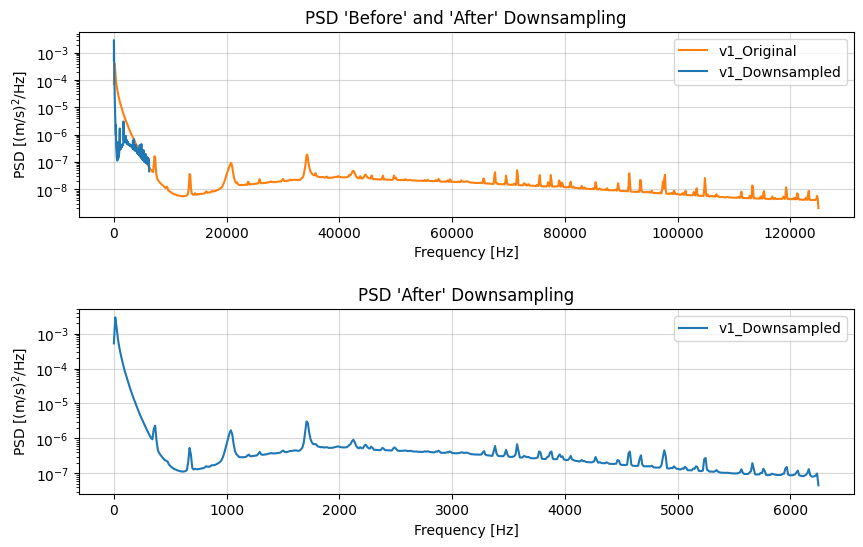

In [9]:
"""
------------------------ TASK 1.3 -----------------------------------------------
We verified that the downsampled signal still retains the dominant frequency content. This 
confirms that the filtering and downsampling did not distort the meaningful turbulent structures.
Plot and compare PSD Before and After for "v1" velocity

"""

# computing PSD using welch method, for filtered and donwsampled velocity turbulence data
# keeping the "time window size" same, by modifying "nperseg" value in computing PSD
f_v1_down, Pxx_v1_down = welch(data[:, 0], fs=fs_down, nperseg=1024)


# plotting before-after PSD comparison for velocity "v1"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.5)
ax1.semilogy(f_v1, Pxx_v1, label='v1_Original', color='tab:orange')
ax1.semilogy(f_v1_down, Pxx_v1_down, label='v1_Downsampled', color='tab:blue')
ax2.semilogy(f_v1_down, Pxx_v1_down, label='v1_Downsampled', color='tab:blue')
ax1.set_title("PSD 'Before' and 'After' Downsampling")
ax2.set_title("PSD 'After' Downsampling")
for ax in (ax1, ax2):
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('PSD [(m/s)$^2 $/Hz]')
    ax.legend()
    ax.grid(alpha=0.5)
plt.show()

### Task 1.4

In [5]:
"""
------------------------ TASK 1.4 -----------------------------------------------
Each of the four filtered and downsampled velocity components was detrended by 
subtracting its mean to isolate the fluctuating part of the turbulent signal. 
These fluctuating signals were then segmented into non-overlapping blocks of 2048 
samples, resulting in 488 blocks per signal.
"""

# Subtracting mean to get fluctuations ==> as we want to study u', not the mean U
fluctuations = filtered_downsampled_data - np.mean(filtered_downsampled_data, axis=1, keepdims=True)

# Now reshape into blocks of 2048 measurements each
block_size = 2048
n_samples = fluctuations.shape[1]         # 1000000
n_blocks = n_samples // block_size

# Truncate and reshape
blocks = fluctuations[:, :n_blocks * block_size].reshape(data.shape[1], n_blocks, block_size)

# blocks shape: [4 channels, n_blocks, 2048]
print(f'Reshaped data for all {blocks.shape[0]} velocities in {blocks.shape[1]} blocks of {blocks.shape[2]} measurements each')


Reshaped data for all 4 velocities in 488 blocks of 2048 measurements each


### Task 1.5 -&- Task 1.6

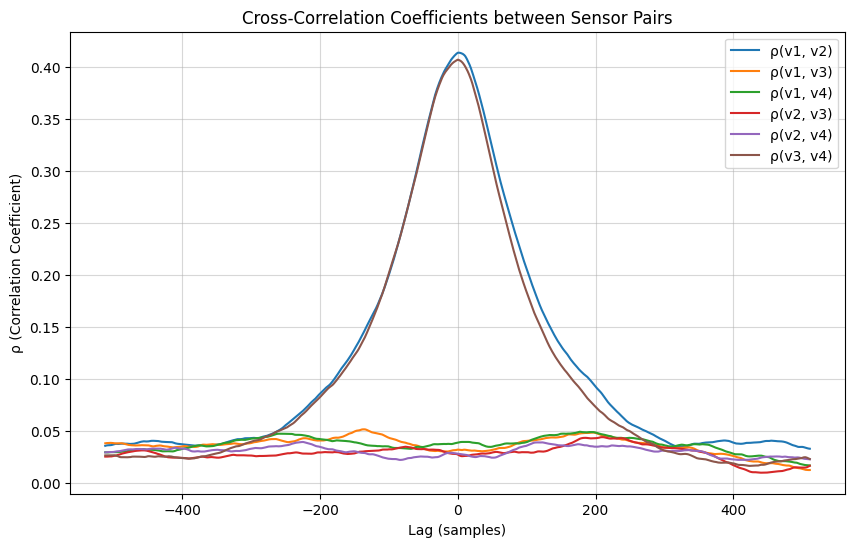

In [6]:
"""
------------------------ TASK 1.5 -----------------------------------------------
We computed the transverse cross-correlation coefficient functions between all unique pairs of 
hot-wire channels. For velocity signals of non-overlapping blocks of 2048 samples, we computed :
    - Unique Cross-correlation: for lags [−512, +511]

All correlations were averaged over all blocks and normalised to obtain correlation coefficients. 
These functions now quantify the time-lagged similarity of the turbulent velocity fluctuations 
between spatially separated hot-wire probes.
This reveals how turbulence is spatially coherent between sensor locations.
"""

max_lag = 512                            # symmetric +-512
lags = np.arange(-max_lag, max_lag)
n_blocks = blocks.shape[1]               # number of block
Ns_b = blocks.shape[2]                   # samples per block

# Empty dictionary to store results
R_dict = {}                              # store raw averaged cross-correlations (not normalised)
rho_dict = {}                            # store correlation coefficients (normalised)

# Loop over unique channel pairs (no self-pairs, no duplicates)
for i, j in combinations(range(4), 2):   # building i,j combinations for 4 number of channels

    R_ij = np.zeros(2 * max_lag)         # (positive, and negative both lags) : [-512,+511]
    for b in range(n_blocks):
        v_i = blocks[i, b, :]            # shape: (2048,)
        v_j = blocks[j, b, :]            # shape: (2048,)

        # Computing Cross-correlation
        R_ij_full = np.correlate(v_i, v_j, mode="same")
        R_ij += R_ij_full[Ns_b//2 - max_lag : Ns_b//2 + max_lag]    # both positive and negative lags

    # Average over all blocks and normalize by block length
    R_ij = R_ij / (n_blocks * Ns_b)
    R_dict[(i, j)] = R_ij                # array of shape (1024,) => raw, averaged cross-correlation function R_vi_vj(tau)



    """
    ------------------------ TASK 1.6 -----------------------------------------------

    """
    
    # Global std (across all blocks and time) for v_i and v_j
    std_i = np.std(blocks[i, :, :])
    std_j = np.std(blocks[j, :, :])

    
    rho_ij = R_ij / (std_i * std_j)      # Normalize: cross correlation coefficient
    rho_dict[(i, j)] = rho_ij            # Save correlation coefficients


# Plotting Cross-Correlation coefficients
plt.figure(figsize=(10, 6))
for (i, j), rho in rho_dict.items():
    plt.plot(lags, rho, label=f'ρ(v{i+1}, v{j+1})')
    
plt.title("Cross-Correlation Coefficients between Sensor Pairs")
plt.xlabel("Lag (samples)")
plt.ylabel("ρ (Correlation Coefficient)")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

"""
The plots of correlation coefficients show :
- The strongest peak correlation occurs between rho(v1,v2), followed very closely by rho(v3,v4) channel pair. 
- Both above peaks near lag=0, with max around 0.42, suggesting very strong, synchronised fluctuations.
- The rest - (v1,v3), (v1,v4), (v2,v3), and (v2,v4) - show very low and flat correlations (value near 0.03-0.05)
- This means turbulence fluctuations decorrelate quickly with increasing sensor separation.
- This pattern is physically consistent with turbulent flow behaviour, where coherent structures decay over 
distance and spatially separated sensors become less correlated.
""";

### Task 1.7

In [7]:
"""
------------------------ TASK 1.7 -----------------------------------------------
These cross-correlation results clearly show that:
- Sensor pairs that are spatially closest (5 cm apart) — like (v1–v2) and (v3–v4) — exhibit the 
strongest cross-correlation.
- As the transverse separation increases (e.g., v1–v4 --> 15 cm), the correlation drops off sharply
"""

# Ranking of cross-correlation pairs by max absolute ρ values
correlation_strengths = []
for (i, j), rho in rho_dict.items():
    max_corr = np.max(np.abs(rho))
    correlation_strengths.append(((i, j), max_corr))

correlation_strengths_sorted = sorted(correlation_strengths, key=lambda x: x[1], reverse=True)

# Print ρ value in descending order
print('Maximum absolute cross-correlation coefficient, ranked in descending order of correlation strength :')
for (i, j), val in correlation_strengths_sorted:
    print(f"Pair v{i+1}–v{j+1}: max |ρ| = {val:.4f}")


Maximum absolute cross-correlation coefficient, ranked in descending order of correlation strength :
Pair v1–v2: max |ρ| = 0.4137
Pair v3–v4: max |ρ| = 0.4070
Pair v1–v3: max |ρ| = 0.0513
Pair v1–v4: max |ρ| = 0.0489
Pair v2–v3: max |ρ| = 0.0437
Pair v2–v4: max |ρ| = 0.0391


### Task 1.8

In [8]:
"""
------------------------ TASK 1.8 -----------------------------------------------
From the above Task 1.7 :
Pair v1–v2:  5cm : max |ρ| = 0.4137 ---> Highest correlation
Pair v3–v4:  5cm : max |ρ| = 0.4070 ---> High correlation
Pair v1–v3: 10cm : max |ρ| = 0.0513 ---> Weak correlation
Pair v1–v4: 15cm : max |ρ| = 0.0489 ---> Weak correlation
Pair v2–v3:  5cm : max |ρ| = 0.0437 ---> Weak correlation
Pair v2–v4: 10cm : max |ρ| s= 0.039  ---> Weak correlation

The results clearly show that :
- Sensor pairs that are spatially closest (5 cm apart) — like (v1–v2) and (v3–v4) — exhibit the 
strongest cross-correlation, with the peak values around 0.42.
- As the transverse separation increases (e.g., v1–v4 --> 15 cm), the correlation drops off sharply, 
indicating that turbulent velocity fluctuations decorrelate quickly over distance.
- This behaviour physically indicates the presence of coherent eddies or structures that possess finite 
spatial extent. Beyond a certain separation, sensors begin to sample statistically independent fluctuations.
""";